In [1]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

from pathlib import Path

data_dir = Path('/app/notebooks/image_stitching/sample_data/')
assert data_dir.exists()

In [2]:
device = torch.device('cuda:0')

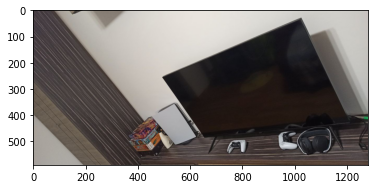

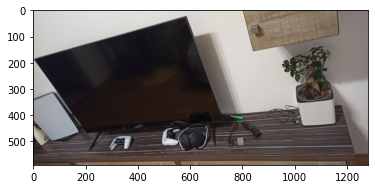

In [11]:
img1 = Image.open(data_dir / 'sample1.jpg')
img2 = Image.open(data_dir / 'sample2.jpg')

timg1 = kornia.utils.image_to_tensor(np.array(img1), False).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(img2), False).float() / 255.

timg1 = timg1.to(device)
timg2 = timg2.to(device)

timg = torch.cat([timg1,timg2], dim=0)

timg_gray = kornia.color.rgb_to_grayscale(timg)

plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

In [12]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

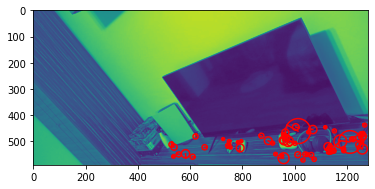

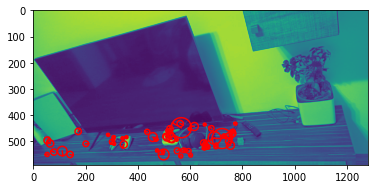

67 inliers


In [13]:
#Now lets try with Difference-of-Gaussians + OriNet + TFeat

PS = 41

sift = kornia.feature.TFeat(True).to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)

descriptor = sift

resp = BlobDoG()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)

nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 4000
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              scale_space_response=True,#We need that, because DoG operates on scale-space
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(32, 
                                                                    angle_detector=kornia.feature.OriNet(True)),
                              mr_size=6.0,
                              minima_are_also_good=True).to(device) #dark blobs are as good as bright.

with torch.no_grad():
    lafs, resps = detector(timg_gray)
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, lafs, PS)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
    scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9)

# Now RANSAC
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 10000)

inliers = matches[torch.from_numpy(mask).bool().squeeze(), :]

for i in range(2):
    visualize_LAF(timg_gray, lafs[:,inliers[:,i]], i)
print (len(inliers), 'inliers')

In [14]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):
    """ converting the keypoints to numpy arrays before passing them for calculating Homography Matrix.
    
    Because we are supposed to pass 2 arrays of coordinates to cv2.findHomography, as in I have these points in image-1, and I have points in image-2, so now what is the homography matrix to transform the points from image 1 to image 2
    """
    ''' For findHomography() - I need to have an assumption of a minimum of correspondence points that are present between the 2 images. Here, I am assuming that Minimum Match Count to be 4 '''
    if len(matches) > 4:
        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(keypoints_train_img, keypoints_query_img, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [15]:
M = homography_stitching(src_pts, dst_pts, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 1.60173334e+00 -2.86019984e-01 -6.32121058e+02]
 [ 2.63485347e-01  1.46512099e+00 -2.64839171e+02]
 [ 5.20174455e-04 -3.38337869e-05  1.00000000e+00]]


In [27]:
# For the calculation of the width and height of the final horizontal panoramic images 
# I can just add the widths of the individual images and for the height
# I can take the max from the 2 individual images.

nimg1 = timg1.cpu()[0].permute(1,2,0).numpy()
nimg2 = timg2.cpu()[0].permute(1,2,0).numpy()

width = nimg1.shape[1] + nimg2.shape[1] + 200
print("width ", width) 

height = max(nimg1.shape[0], nimg2.shape[0]) + 400

result = cv2.warpPerspective(nimg1, Homography_Matrix,  (width, height))

# # # The warpPerspective() function returns an image or video whose size is the same as the size of the original image or video. Hence set the pixels as per my query_photo

# result[0:nimg2.shape[0], 0:nimg2.shape[1]] = nimg2

# plt.figure(figsize=(20,10))
# plt.axis('off')
# plt.imshow(result)

width  2760


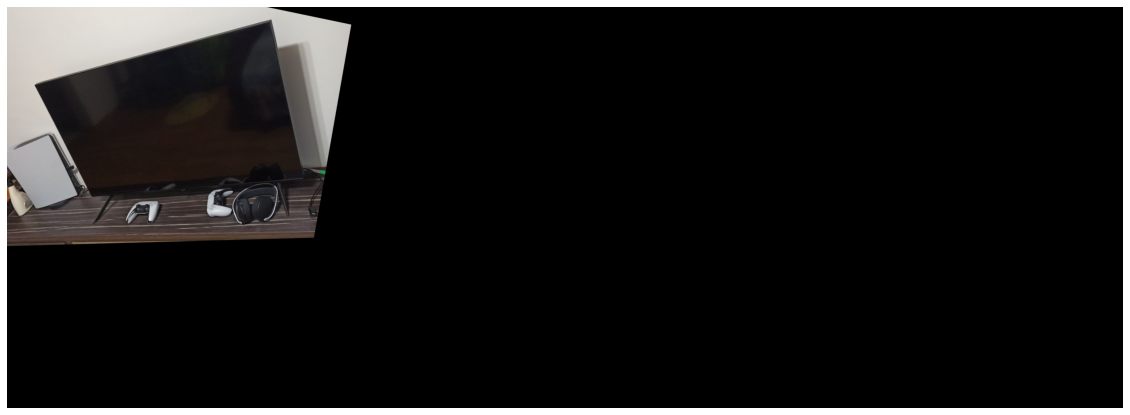

In [28]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)

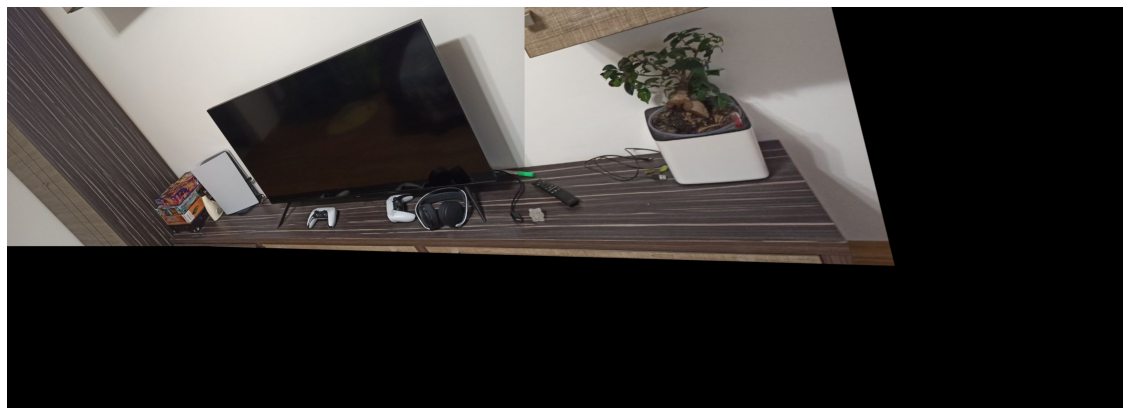

In [10]:
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)